In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from __future__ import division

import os

import numpy as np

from glob import glob

import reduce_dblspec 

from astropy.io import fits
from astropy import units as u
from astropy import modeling
from astropy.table import Table

from astropy import modeling
from astropy import constants as cnst

## General Procedure
#### Overscan/Bias
#### Small Scale Flat
#### Combine exposures
#### Sky subtration
#### Extract Target Spectrum & collapse to 1D

How to use this pipeline for Dispersion Solution:

1. define ALL files to be used in reduction (see example for list)
2. set specset = dispersion fcn to use in guess_plot
3. use dispersion outputted graphs to estimate wl & pixel matches
4. use guess_plot to get linelist matches to refine pixel estimates 
5. collect ~5 of these in lists
6. use goodness_of_matches to populate more matches based on inital guesses & plot residuals
7. if satisfied, set ds = goodness_of_matches; this is the dispersion solution now

How to extract 1D Spectrum of Target---for each side!
1. define a targetID & skyaps
2. run sky_subtract and refine skyaps based on first graph produced
3. if satisfied set flux, unc = sky_subtract; this is the target's 1D flux spectrum for that side

How to combine red & blue sides to get one complete target spectrum
1. working on it

In [3]:
def guess_plot(pxguess, wlguess, specset, pxwindw=300, wlwindow=400): 
    fig, (ax1, ax2) = plt.subplots(1,2)

    ds, wlatlas, specatlas, linelist = specset 
    
    #use these graphs to refine matching of arcs to atlas
    
    #first graph 
    plt.axes(ax1)
    ds.plot_spec() #1D spectrum of dispersion solution or is this the arc..waiting on eriks answer
    plt.axvline(pxguess, color='k', ls=':') #plot a vertical line where think peak pixel is in emission lines
    plt.xlim(pxguess-pxwindw/2, pxguess+pxwindw/2)
    #plt.ylim(0, np.max(ds.spec1d[plt.xlim()[0] : plt.xlim()[1]])*1.05)
    plt.title('DS 1D Spectrum')

    
    #second graph
    plt.axes(ax2)
    plt.plot(wlatlas, specatlas) #plots what atlas spectrum looks like
    plt.title('Atlas 1D Spectrum')
    plt.axvline(wlguess, color='k', ls=':')
    plt.xlim(wlguess-wlwindow/2, wlguess+wlwindow/2)
    
    #defs the min & max wavelength peaks to use to scale in next lines
    minpx = np.argmin(np.abs(wlatlas-(wlguess-wlwindow/2)))
    maxpx = np.argmin(np.abs(wlatlas-(wlguess+wlwindow/2)))
    
  
    
    #sets wavelength scales based on graph size-ish
    plt.ylim(0, specatlas[minpx:maxpx].max()*1.05)
    guess = reduce_dblspec.nearest_in_line_list(wlguess, linelist)
    plt.axvline(guess[0], color='r', ls=':') #for 1st wavelength to linelist match draw red vertical line
    
    return guess #outputs wavelength guesses based on atlas spec known linelists

In [18]:
def dispersion(all_side_files,atlasfiles,arcfiles,linelist):
    #Overscan the flats
    flats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj('DomeFlat',all_side_files)[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
    #note above only works if all output headers include 'DomeFlat'
    
    #small scale flat creationg - normalized
    nfl = reduce_dblspec.create_normalized_flat(flats)

    header = atlasfiles[0].header    
    specnoao = atlasfiles[0].data
    wlnoao = header['CRVAL1'] + header['CD1_1']*(np.arange(len(specnoao)) - header['CRPIX1'] + 1) #+1 is for 0-based

    #creating dispersion solution
    ds = reduce_dblspec.DispersionSolution(reduce_dblspec.DoubleSpecImage(arcfiles).overscan_sub_and_trim().flatten(nfl), (320, 360))
    
    #print(header['IRAFNAME']) 
    
    #outputs graphs of atlas
    plt.figure(figsize=(20,5))
    plt.plot(wlnoao, specnoao)
    plt.title('Atlas 1D Spectrum-wavelengths')
    plt.xlabel('wavelengths')
    #atlas plot axis range limit choices
    if header['IRAFNAME']=='henear.spec': #redside
        #print('red') #tested & worked
        print('used atlas plot limits for Red side')
        plt.xlim(5000,10000)
    elif header['IRAFNAME']=='FeAr.spec': #blueside
        #print('blue') #tested & worked
        print('used atlas plot limits for Blue side')
        plt.xlim(3000,5500)
        plt.ylim(0,5e5) #how to make this more flexible?
    else: #not sure why this prints for redside b/c its still choosing the correct xrange&blue does too
        print("can't determine camera side for atlas plot limits based on:",header['IRAFNAME'])
        #raise ValueError("Can't determine camera side ")    
    
    #outputting arc graph so can guess lines
    plt.figure(figsize=(20,5))
    plt.xlabel('pixels')
    plt.title('Arc Lamp 1D Spectrum-pixels')
    ds.plot_spec()
    #extra condition just for blue side orientation b/c of camera inversion to make comparison to atlas easier
    if header['IRAFNAME']=='FeAr.spec': #blueside
        plt.xlim([2800,0]) #for arc
    
    specset = (ds, wlnoao, specnoao,linelist)
    return (specset) #returns input for guess_plot along with graphs to make pixel & wl guesses

In [5]:
def goodness_of_matches(arcfiles, guesses,all_side_files, atlasfiles,linelist):
    flats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj('DomeFlat',all_side_files)[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
    #note above only works if all output headers include 'DomeFlat'
    #outputs = []
    #small scale flat creationg - normalized
    nfl = reduce_dblspec.create_normalized_flat(flats)
    header = atlasfiles[0].header    
    
    arcimg = reduce_dblspec.DoubleSpecImage(arcfiles).overscan_sub_and_trim().flatten(nfl)
    
    #print(header['IRAFNAME'])
    if header['IRAFNAME']=='henear.spec': #redside
        print('chose ds for redside')
        ds = reduce_dblspec.DispersionSolution(arcimg, (320, 360), poly_order=3)
        #print('ds for red')
    elif header['IRAFNAME']=='FeAr.spec': #blueside
        print('chose ds for blueside')
        ds = reduce_dblspec.DispersionSolution(arcimg, (205, 260), poly_order=3)
    else:#for some reason this prints AS WELL AS prints indicating red side choosen for red side only, blue works fine
        print("camera side for ds not understood based on:",header['IRAFNAME'])
        #raise ValueError("Can't determine camera side ")


    
    outputs = []
    for i in guesses:
            list_a = ds.guess_line_loc(i[0], i[1]) #guesses(pixel, wl)
            outputs.append(list_a) #why am i collecting these? where are they used?
            
    #print(header['IRAFNAME'])
    if header['IRAFNAME']=='FeAr.spec': #blueside
        print('chose guesses for blueside')
        ds.guess_from_line_list(linelist,minpeakratio=5, continuous_fit=True, sigmaclip=True, max_wl=5400)    
    elif header['IRAFNAME']=='henear.spec': #redside
        print('chose guesses for redside')
        ds.guess_from_line_list(linelist,minpeakratio=10, continuous_fit=True, sigmaclip=True, min_wl=5600)
    else:
        print("camera side for guesses not understood based on:",header['IRAFNAME'])
        #raise ValueError("Can't determine camera side ")
        #ds.guess_from_line_list(linelist,minpeakratio=10, continuous_fit=True, sigmaclip=True, min_wl=3000)
    



    #1st graph-residuals
    plt.figure(figsize=(20,5))
    residuals = ds.plot_solution(True)  
    #2nd graph-populated matches, px to wl;want linear 
    plt.figure(figsize=(20,5))
    ds.plot_spec_wl()
    
    return (ds) 

In [6]:
#skyaps=[(lower bound pixel location in (x,y), upper bound pixel location in (x,y))]
#play with vmax & vmin to get better contrast
def sky_subtract(targetID,skyaps,ds,all_side_files,atlasfiles):
    #need these again -flats/overscan
    flats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj('DomeFlat',all_side_files)[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
    nfl = reduce_dblspec.create_normalized_flat(flats)
    
    header = atlasfiles[0].header    


    
    #locating all files w/ the target & flat/overscan subt
    specs = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim().flatten(nfl) 
          for fn in reduce_dblspec.find_all_obj(targetID,all_side_files)]
    
    
    print(len(specs))


    
    
    #stacking all that data for specific target-help increase s/n 
    comb = reduce_dblspec.combine_imgs(specs)
    
    
    
    
    
    #plotting 2D to get skyaps right around the target
    plt.figure(figsize=(20,10)) #setting up fig size
    subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0))
    plt.subplot(211)
    plt.title('2D spec - Verify skyaps for correct target extraction')
    if header['IRAFNAME']=='FeAr.spec': #blueside
        print('choose 2D spec for blueside')
        subimg.show_image(transpose=True,vmax=40,vmin=-10)
    elif header['IRAFNAME']=='henear.spec': #redside
        print('choose 2D spec for redside')
        subimg.show_image(transpose=False,vmax=40,vmin=-10) 
    else:
        print("camera side for 2D spec not understood based on:",header['IRAFNAME'])
        #raise ValueError("Can't determine camera side ")    
    
    
    #setting up 1D extraction of target
    #setting up extraction range based on sky apps not sure if these is good to do b/c depends on extension of gal size
    begin = (skyaps[0][0] + 60)
    print ('this is beginning value of target spec extraction:',begin)
    end = (skyaps[1][0] - 30)
    print('this is end value of target spec extraction:',end)
    flux, unc = subimg.extract_spectrum((begin,end))
    
    #plotting 1D extraction of target
    plt.subplot(212)
    plt.step(ds.pixtowl(np.arange(len(flux))), flux)
    plt.title('1D Target Spectrum')
    plt.ylabel('flux -- but ask Erik to be sure (counts/units?)')
    plt.xlabel('wavelength')
    #based below limit choices on info on palomar dblspec webpage
    if header['IRAFNAME']=='FeAr.spec': #blueside
        print('choose 1D target spec axis limits for blueside')
        plt.xlim(2800, 7000) #3600,5800 
        plt.ylim(0, plt.ylim()[-1])
    elif header['IRAFNAME']=='henear.spec': #redside
        print('choose 1D target spec axis limits for redside')
        plt.xlim(4700, 11000)
        plt.ylim(0, plt.ylim()[-1])

    
    return (flux, unc)



In [7]:
#probably need to fix this to do adding with interp

def combine_red_blue(ds_red,ds_blue,flux_red,flux_blue):
    wl = np.append(ds_red.pixtowl(np.arange(len(flux_red))), ds_blue.pixtowl(np.arange(len(flux_blue))))
    
    red_and_blue_flux = np.append(flux_red,flux_blue)
    plt.step(wl, red_and_blue_flux)
    plt.xlabel('wavelength')
    plt.ylabel('?? flux??')
    plt.title('1D Spectrum for Target')
    plt.ylim(0, max(red_and_blue_flux)) #ok to be 0? ?b/c of negative flux values but thats odd itself..
    return(red_and_blue_flux)

In [8]:
#work on this using a centroid method

#def trace(targetID,skyaps,ds,all_side_files,atlasfiles):



**_Directory of Main Sections_**
- DISPERSION SOLUTIONS - RED 1.5"- RED 1.0"- BLUE 1.5"- BLUE 1.0"
- SKY SUBTRACTION FOR TARGET: ODY_NOSPEC (RED 1.5", BLUE 1.5")
- R/B SIDE COMBINATION FOR TARGET: ODY_NOSPEC

# Dispersion Solutions
### Red (1.5")--ds

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


atlas plot limits for Red side


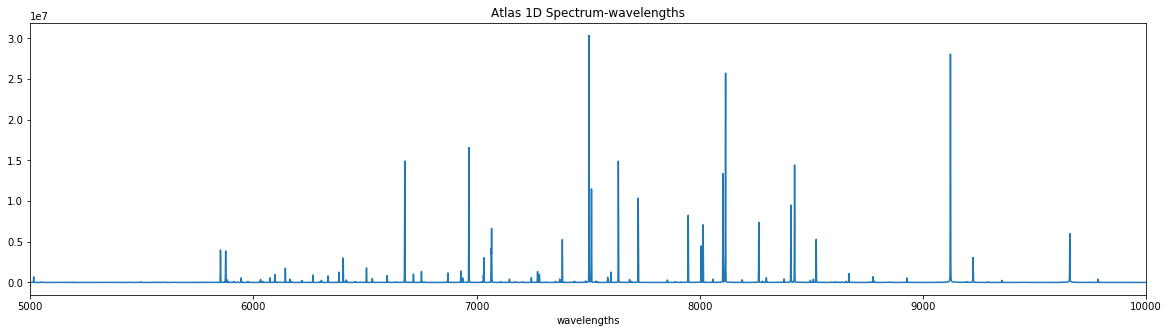

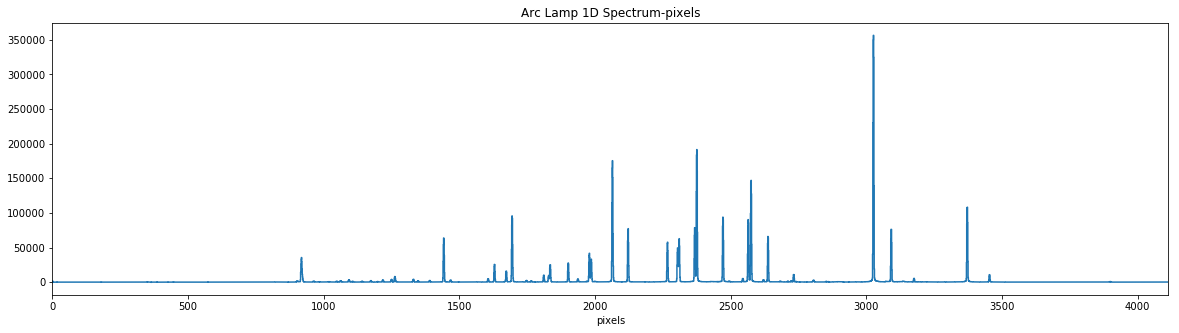

In [10]:
#generating atlas & arc graphs for wl & pixel matching

#nameing all the datafiles needed
all_side_files_red15 = '20170518/red*.fits' #redside
atlasfiles_red15 = fits.open('henear.fits') #NOAO atlas #redside
arcfiles_red15 = '20170518/red0017.fits' #redside
linelist_red15 = reduce_dblspec.HENEAR_LINE_LIST #must be in this form cant use'henearhres.dat'-debug later

#naming pipeline output for guess_plot use
specset_red15 = dispersion(all_side_files_red15, atlasfiles_red15, arcfiles_red15, linelist_red15)

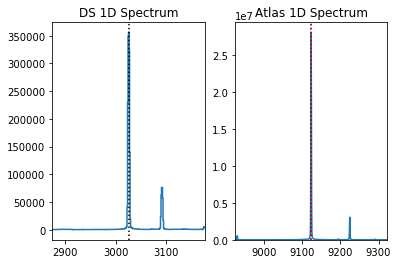

In [12]:
#collecting guesses of matching lines from above graphs

#entering (px,wl)guesses & data
guess_plot(3025.5,9122.9674,specset_red15) #outputs (pixel guess, nearest wl/id in linelist)

#collect those guesses here ~5 seems good
pixel_guesses_red15 = [3372,3027,2375,2065,1630]
atlas_lines_red15 = [9657.78,9122.9674,8115.31,7635.1,6965.43]
guesses_red15 = list(zip(pixel_guesses_red15, atlas_lines_red15)) #making tuples to pass into fcn later

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for redside
chose guesses for redside
Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480

Failed to find line KrI at wl=7685.246: "Guessed line's peak to base ratio is 0.9961512863913919, which is less than 10"
Failed to find line KrI at wl=7694.5393: "Guessed line's peak to base ratio is 1.0578827797865025, which is less than 10"
Failed to find line KrI at wl=7854.8215: "Guessed line's peak to base ratio is 0.8644155931496915, which is less than 10"
Failed to find line ArI at wl=7891.075: "Guessed line's peak to base ratio is 0.9941144590061228, which is less than 10"
Failed to find line KrI at wl=7913.4242: "Guessed line's peak to base ratio is 1.0229280821470732, which is less than 10"
Found line ArI at wl=7948.1764
Clipped 0 lines
Failed to find line ArI at wl=8006.1567: "Guessed line's peak to base ratio is 4.148138032795113, which is less than 10"
Failed to find line ArI at wl=8014.7857: "Guessed line's peak to base ratio is 3.3988140467662045, which is less than 10"
Failed to find line KrI at wl=8059.5038: "Guessed line's peak to base ratio is 0.9784268022083137, whi

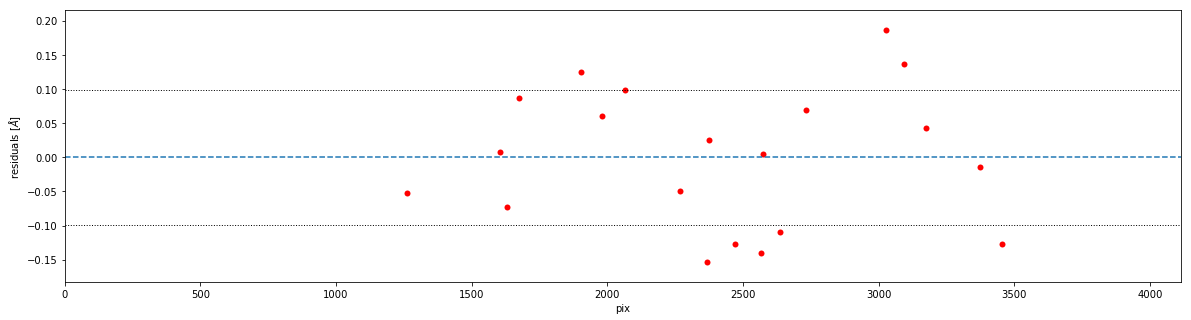

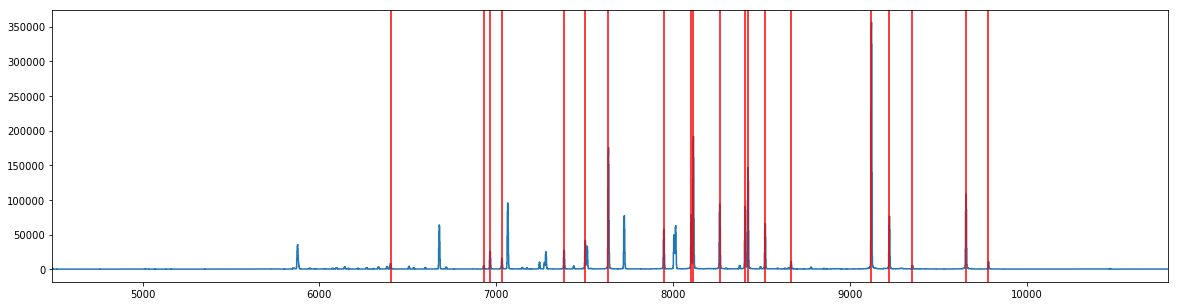

In [13]:
#generating more line matches based on guesses above and checking residuals to see if this is a good enough solution

ds_red15 = goodness_of_matches(arcfiles_red15,guesses_red15,all_side_files_red15,atlasfiles_red15,linelist_red15)

### Red (1.0") --ds

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


atlas plot limits for Red side


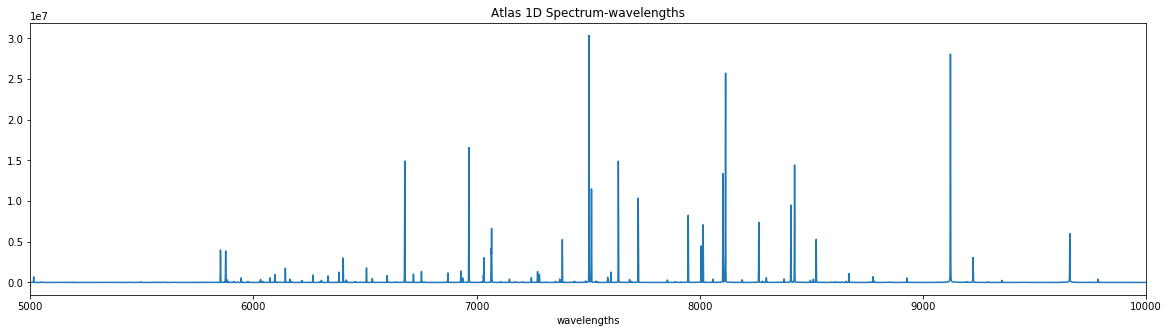

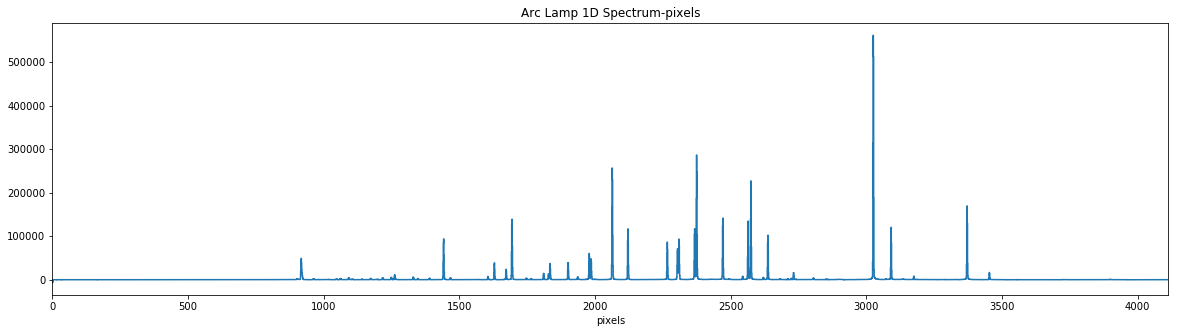

In [14]:
#nameing all the datafiles needed
all_side_files_red10 = '20170518/red*.fits' #redside
atlasfiles_red10 = fits.open('henear.fits') #NOAO atlas #redside
arcfiles_red10 = '20170518/red0012.fits' #redside
linelist_red10 = reduce_dblspec.HENEAR_LINE_LIST

specset_red10 = dispersion(all_side_files_red10, atlasfiles_red10, arcfiles_red10, linelist_red10)

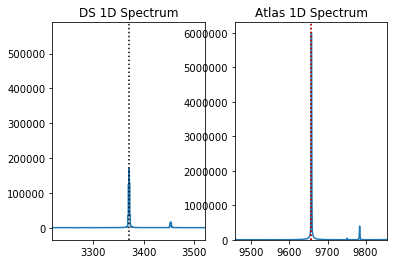

In [15]:
#collecting guesses of matching lines from above graphs

#entering (px,wl)guesses & data
guess_plot(3370,9657,specset_red10) #outputs (pixel guess, nearest wl/id in linelist)

#collect guesses here ~5 seems good
pixel_guesses_red10 = [3024,2373,2062,1672,3370]
atlas_lines_red10 = [9122.9674,8115.311,7635.106,7032.4131,9657.7863]
guesses_red10 = list(zip(pixel_guesses_red10, atlas_lines_red10)) #making tuples to pass into fcn later

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for redside
chose guesses for redside
Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480

Failed to find line KrI at wl=7587.413: "Guessed line's peak to base ratio is 1.0819554378142586, which is less than 10"
Failed to find line KrI at wl=7601.5443: "Guessed line's peak to base ratio is 1.0525916052067257, which is less than 10"
Found line ArI at wl=7635.106
Clipped 0 lines
Failed to find line KrI at wl=7685.246: "Tried to find peak at 2095.7102377360125 but it's in a valley, not a peak"
Failed to find line KrI at wl=7694.5393: "Guessed line's peak to base ratio is 0.9487211223641862, which is less than 10"
Failed to find line KrI at wl=7854.8215: "Guessed line's peak to base ratio is 1.1041302787798228, which is less than 10"
Failed to find line ArI at wl=7891.075: "Guessed line's peak to base ratio is 1.1153847553894787, which is less than 10"
Failed to find line KrI at wl=7913.4242: "Tried to find peak at 2243.4658680624693 but it's in a valley, not a peak"
Found line ArI at wl=7948.1764
Clipped 0 lines
Failed to find line ArI at wl=8006.1567: "Guessed line's peak to b

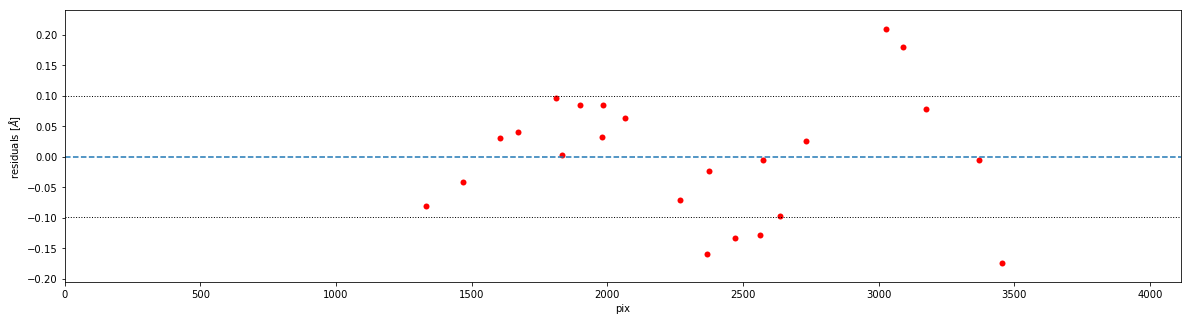

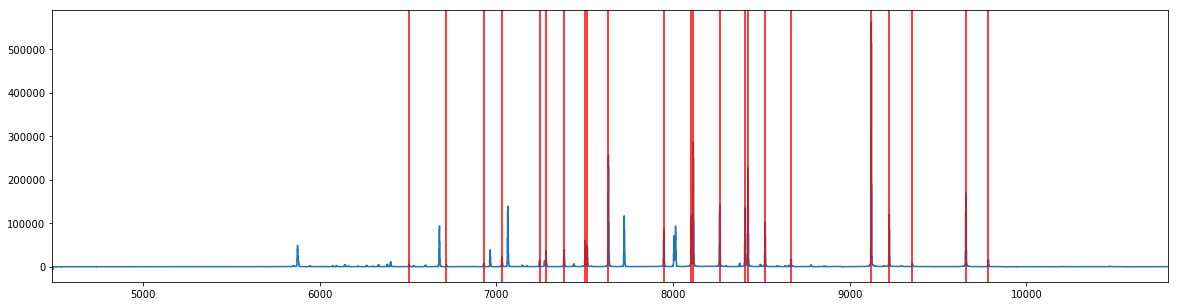

In [16]:
#generating more line matches based on guesses above and checking residuals to see if this is a good enough solution

ds_red10 = goodness_of_matches(arcfiles_red10,guesses_red10,all_side_files_red10,atlasfiles_red10,linelist_red10)

### Blue (1.5") --ds

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


atlas plot limits for Blue side
not sure how to get around inverting arc blue cam side to look similar to atlas 1D spec...
b/c when use guess plot it appears in original orientation (which can be confusing at first)


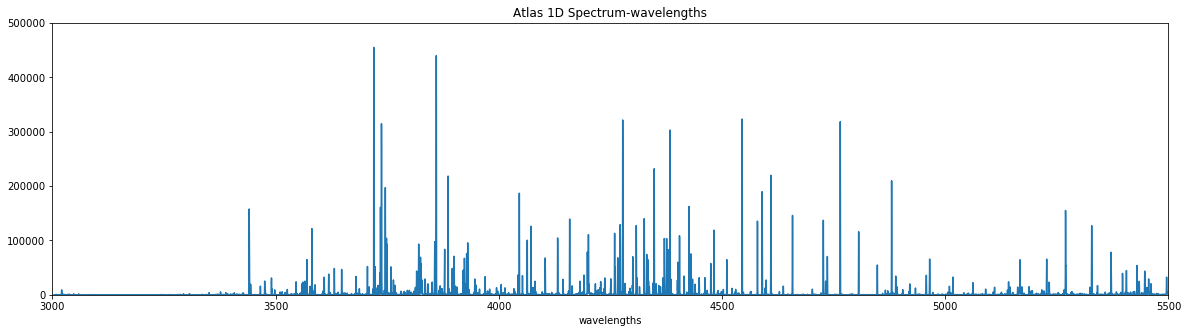

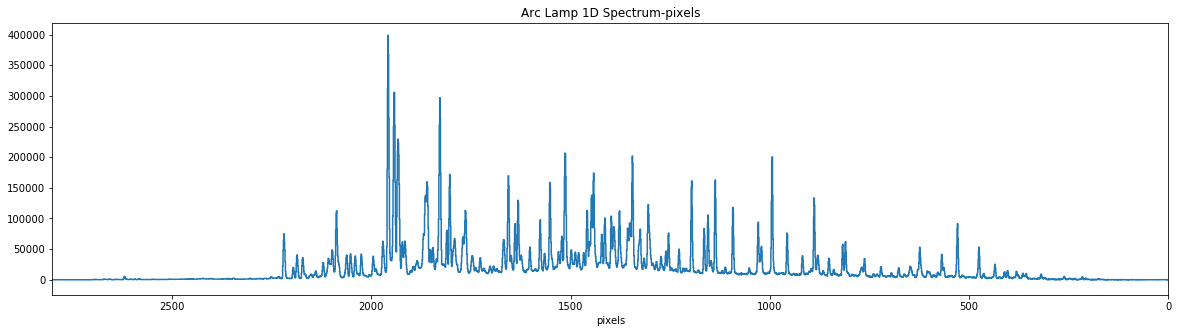

In [17]:
all_side_files_blue15 = '20170518/blue*.fits' #blueside
atlasfiles_blue15 = fits.open('fear.fits') #NOAO atlas #blueside
arcfiles_blue15 = '20170518/blue0018.fits' #blueside
linelist_blue15 = reduce_dblspec.FEAR_LINE_LIST #must be in this form cant use'fear.dat'--debug later

specset_blue15 = dispersion(all_side_files_blue15, atlasfiles_blue15, arcfiles_blue15, linelist_blue15)
print ('not sure how to get around inverting arc blue cam side to look similar to atlas 1D spec...''\n'
       'b/c when use guess plot it appears in original orientation (which can be confusing at first)')

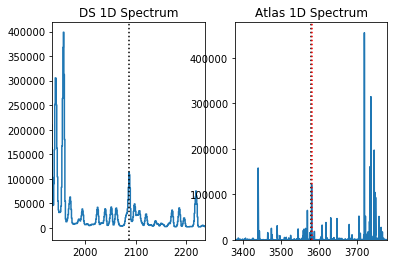

In [19]:
guess_plot(2086,3580,specset_blue15) #(px,wl)

#collect guesses here
pixel_guesses_blue15 = [529,993,1655,1956,2086]
atlas_lines_blue15 = [5269.5366,4764.8646,4044.4179,3719.9346,3581.1925] 

guesses_blue15 = list(zip(pixel_guesses_blue15, atlas_lines_blue15)) #making tuples to pass into fcn later

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for blueside
chose guesses for blueside
Failed to find line FeI at wl=3020.6391: "Guessed line's peak to base ratio is 0.7312268222798526, which is less than 5"
Failed to find line FeI at wl=3024.0325: "Guessed line's peak to base ratio is 3.6415429388607117, which is less than 5"
Failed to find line FeI at wl=3037.3887: "Guessed line's peak to base ratio is 1.046308359334491, which is less than 5"
Failed to find line FeI at wl=3047.6043: "Tried to find peak at 2599.234585866781 but it's in a valley, not a peak"
Failed to find line FeI at wl=3057.4456: "Guessed line's peak to base ratio is 0.9892623976573754, which is less than 5"
Failed to find line FeI at wl=3059.0856: "Guessed line's peak to base ratio is 1.1518908065824378, which is less than 5"
Failed to find line FeI at wl=3225.785: "Guessed line's peak to base ratio is 1.4385738518614017, which is less than 5"
Failed to find line ArII at wl=3243.6887: "Guessed line's peak to base ratio is 1.1305223236157673, which is le

Failed to find line ArII at wl=3946.0971: "Guessed line's peak to base ratio is 2.9612340178890193, which is less than 5"
Failed to find line ArI at wl=3948.9789: "Guessed line's peak to base ratio is 2.9612340178890193, which is less than 5"
Failed to find line FeI at wl=3969.257: "Guessed line's peak to base ratio is 3.0855129661199157, which is less than 5"
Failed to find line ArII at wl=3979.3559: "Guessed line's peak to base ratio is 1.510408904251333, which is less than 5"
Failed to find line ArII at wl=3994.7918: "Guessed line's peak to base ratio is 2.4564854683248716, which is less than 5"
Failed to find line FeI at wl=4005.2414: "Guessed line's peak to base ratio is 2.333333336877587, which is less than 5"
Failed to find line ArII at wl=4033.8093: "Guessed line's peak to base ratio is 3.3812548441217003, which is less than 5"
Found line ArII at wl=4042.8937
Clipped 0 lines
Found line ArI at wl=4044.4179
Clipped 0 lines
Found line FeI at wl=4045.813
Clipped 0 lines
Failed to f

Failed to find line ArI at wl=4702.3161: "Guessed line's peak to base ratio is 3.802637188890531, which is less than 5"
Found line ArII at wl=4726.8683
Clipped 0 lines
Failed to find line ArII at wl=4732.0532: "Tried to find peak at 1025.0238309585625 but it's in a valley, not a peak"
Failed to find line ArII at wl=4735.9058: "Guessed line's peak to base ratio is 2.6965573932394564, which is less than 5"
Found line ArII at wl=4764.8646
Clipped 0 lines
Found line ArII at wl=4806.0205
Clipped 0 lines
Found line ArII at wl=4847.8095
Clipped 0 lines
Failed to find line FeI at wl=4859.7406: "Guessed line's peak to base ratio is 1.5342458864362543, which is less than 5"
Found line ArII at wl=4879.8635
Clipped 0 lines
Failed to find line ArII at wl=4889.0422: "Guessed line's peak to base ratio is 3.1960434069836063, which is less than 5"
Failed to find line FeI at wl=4891.4919: "Guessed line's peak to base ratio is 3.1960434069836063, which is less than 5"
Failed to find line FeI at wl=4920.5

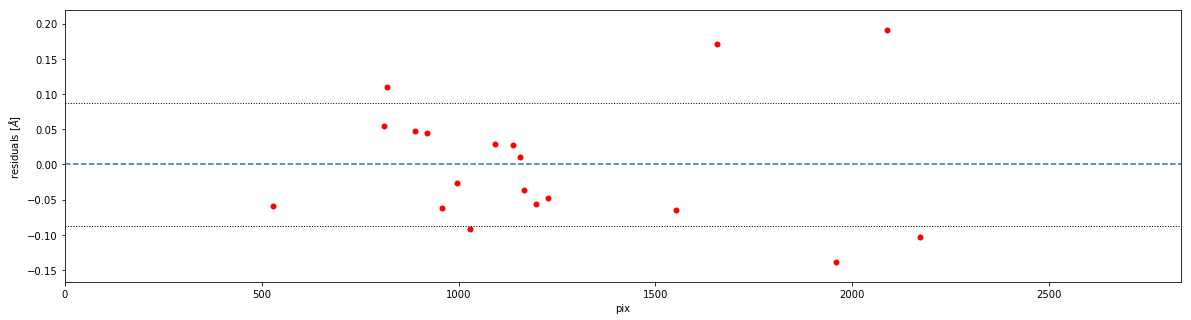

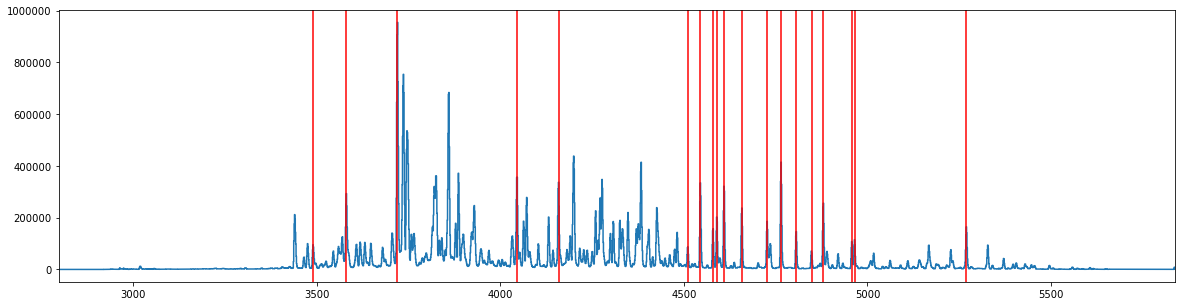

In [20]:
#generating more line matches based on guesses above and checking residuals to see if this is a good enough solution

ds_blue15 = goodness_of_matches(arcfiles_blue15,guesses_blue15,all_side_files_blue15,atlasfiles_blue15,linelist_blue15) #yay looks good FINALLY!!

### Blue (1.0") --ds

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Blue side
not sure how to get around inverting arc blue cam side to look similar to atlas 1D spec...
b/c when use guess plot it appears in original orientation (which can be confusing at first)


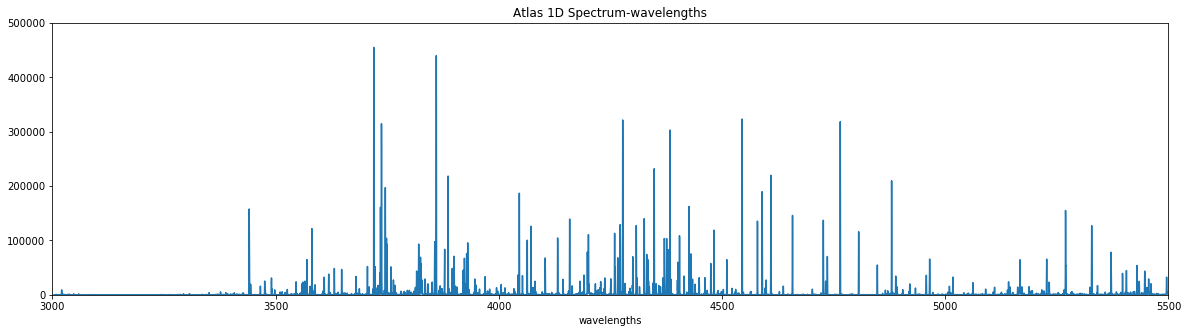

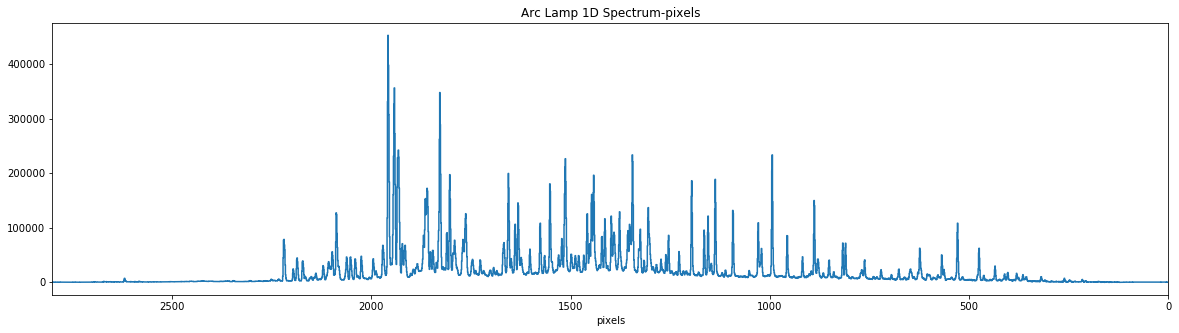

In [21]:
all_side_files_blue10 = '20170518/blue*.fits' #blueside
atlasfiles_blue10 = fits.open('fear.fits') #NOAO atlas #blueside
arcfiles_blue10 = '20170518/blue0011.fits' #blueside
linelist_blue10 = reduce_dblspec.FEAR_LINE_LIST #must be in this form cant use'fear.dat'--debug later

specset_blue10 = dispersion(all_side_files_blue10, atlasfiles_blue10, arcfiles_blue10, linelist_blue10)
print ('not sure how to get around inverting arc blue cam side to look similar to atlas 1D spec...''\n'
       'b/c when use guess plot it appears in original orientation (which can be confusing at first)')

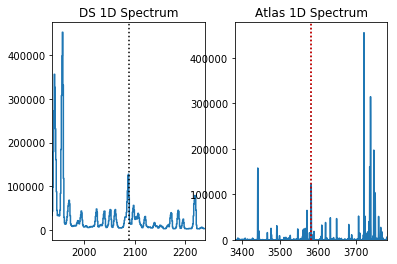

In [22]:
guess_plot(2088,3581,specset_blue10) #(px,wl)

#collect guesses here
pixel_guesses_blue10 = [1958,993,529,1602,1550,1254] 
atlas_lines_blue10 = [3719.9346,4764.8646,5266.5546,4103.91,4158.59,4481.81] 
guesses_blue10 = list(zip(pixel_guesses_blue10, atlas_lines_blue10)) #making tuples to pass into fcn later

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for blueside
chose guesses for blueside
Failed to find line FeI at wl=3020.6391: "Tried to find peak at 2622.141126221478 but it's in a valley, not a peak"
Failed to find line FeI at wl=3024.0325: "Guessed line's peak to base ratio is 3.884537599063041, which is less than 5"
Failed to find line FeI at wl=3037.3887: "Guessed line's peak to base ratio is 0.9729875346430994, which is less than 5"
Failed to find line FeI at wl=3047.6043: "Tried to find peak at 2595.9102217545324 but it's in a valley, not a peak"
Failed to find line FeI at wl=3057.4456: "Tried to find peak at 2586.3520807703403 but it's in a valley, not a peak"
Failed to find line FeI at wl=3059.0856: "Guessed line's peak to base ratio is 2.728611272165076, which is less than 5"
Failed to find line FeI at wl=3225.785: "Guessed line's peak to base ratio is 1.2953062119576328, which is less than 5"
Failed to find line ArII at wl=3243.6887: "Guessed line's peak to base ratio is 1.2666965744164804, which is less than 5

Found line ArII at wl=4609.5673
Clipped 0 lines
Failed to find line ArI at wl=4628.4409: "Guessed line's peak to base ratio is 2.9807834080319333, which is less than 5"
Failed to find line ArII at wl=4637.2328: "Guessed line's peak to base ratio is 4.724066000118576, which is less than 5"
Failed to find line FeI at wl=4647.4329: "Guessed line's peak to base ratio is 1.3333179436576779, which is less than 5"
Found line ArII at wl=4657.9012
Clipped 0 lines
Failed to find line ArI at wl=4702.3161: "Guessed line's peak to base ratio is 4.140896969696224, which is less than 5"
Found line ArII at wl=4726.8683
Clipped 0 lines
Failed to find line ArII at wl=4732.0532: "Guessed line's peak to base ratio is 0.9615901071275994, which is less than 5"
Failed to find line ArII at wl=4735.9058: "Guessed line's peak to base ratio is 2.9949901995248935, which is less than 5"
Found line ArII at wl=4764.8646
Clipped 0 lines
Found line ArII at wl=4806.0205
Clipped 0 lines
Found line ArII at wl=4847.8095
C

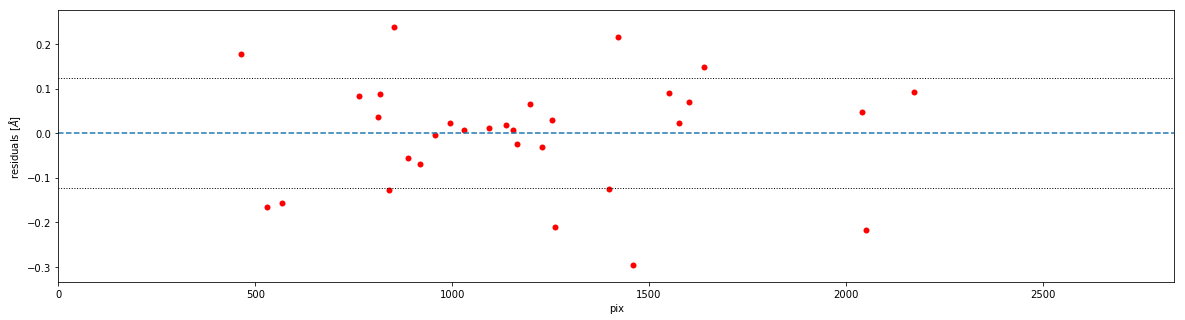

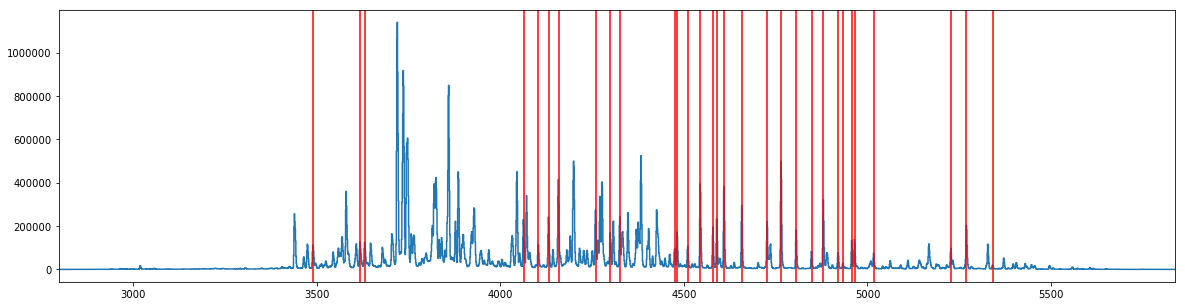

In [23]:
#generating more line matches based on guesses above and checking residuals to see if this is a good enough solution

ds_blue10 = goodness_of_matches(arcfiles_blue10,guesses_blue10,all_side_files_blue10,atlasfiles_blue10,linelist_blue10) #yay looks good FINALLY!!

# Sky Subtraction

### Ody_nospec -- Red (1.5") ss

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


3
choose 2D spec for redside
this is beginning value of target spec extraction: 330
this is end value of target spec extraction: 350
choose 1D target spec axis limits for redside


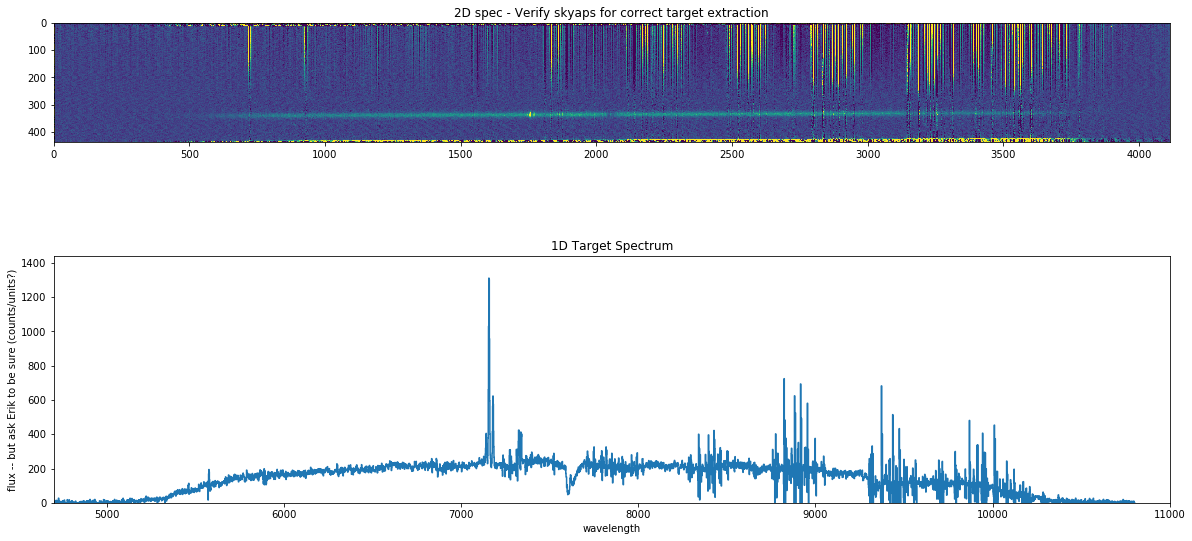

In [24]:
#naming files needed
targetID_red15 = 'Ody_nospec'
skyaps_red15 = [(270,310),(380,410)]

flux_red15,unc = sky_subtract(targetID_red15,skyaps_red15,ds_red15,all_side_files_red15,atlasfiles_red15)

### Ody_nospec -- Blue (1.5") ss 

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


3
choose 2D spec for blueside
this is beginning value of target spec extraction: 85
this is end value of target spec extraction: 105
choose 1D target spec axis limits for blueside
WHY IS THERE NEGATIVE??


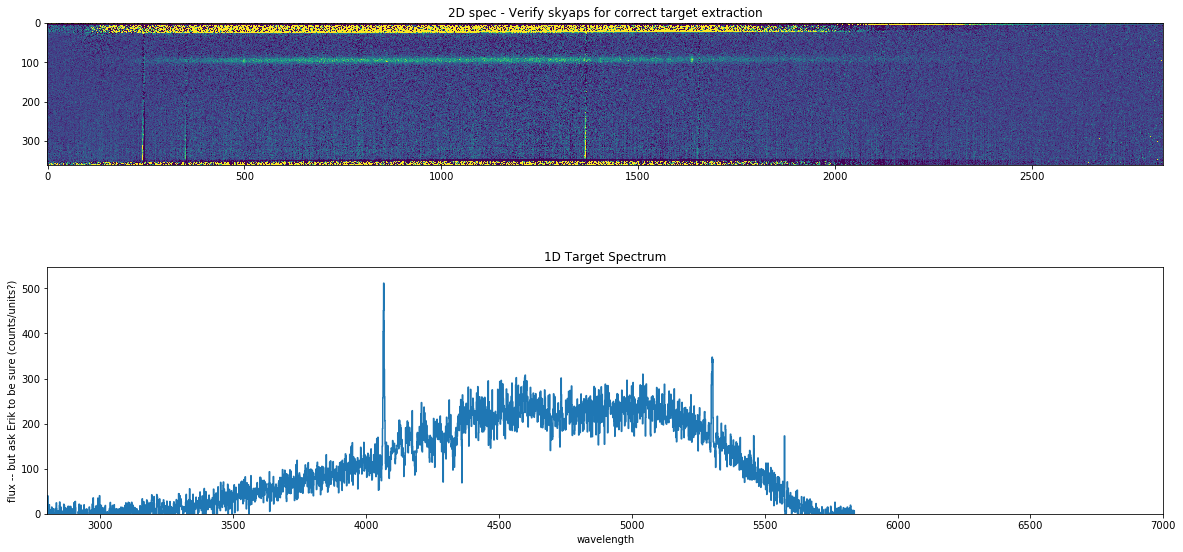

In [25]:
#naming files needed
targetID_blue15 = 'Ody_nospec'
skyaps_blue15 = [(25,80),(135,215)]

flux_blue15,unc_blue15 = sky_subtract(targetID_blue15,skyaps_blue15,ds_blue15,all_side_files_blue15,atlasfiles_blue15)

print('WHY IS THERE NEGATIVE??')

# Combining red & blue sides 
### Ody_nospec (1.5") --R/Bcombined 1D *need flux calibrations still*

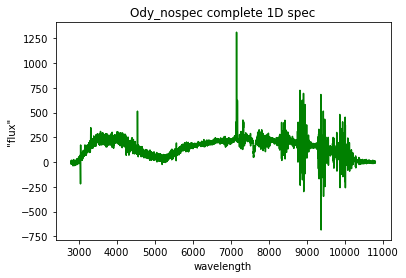

In [30]:
#applying the dispersion solutions for side & slit size
wl_red15 = ds_red15.pixtowl(np.arange(len(flux_red15)))
wl_blue15 = ds_blue15.pixtowl(np.arange(len(flux_blue15)))

#restructuring to work w/ interp & making cuts to avoid strange things at detector edges 
wl_blue15=wl_blue15[::-1] #this reverses the array to become increasing order
flux_blue15=flux_blue15[::-1] #need to also reverse this so associated vals agree w/ wl
flux_red15=flux_red15[2::] #chops off extreme val -1310.395.. & second extreme +1000 val
wl_red15=wl_red15[2::] #matched flux chop

#combining wls & flux for both sides
wl_both = np.concatenate([wl_red15, wl_blue15])
wl_both = np.sort(wl_both)   
rspec = np.interp(wl_both,wl_red15,flux_red15,left=0) #need to do so doesnt repeat first val
bspec = np.interp(wl_both,wl_blue15,flux_blue15,right=0) #need so doesnt repeat last val

#this is the actual adding step & plotting
rbspec = rspec + bspec
plt.xlabel('wavelength')
plt.ylabel('"flux"')
plt.title('Ody_nospec complete 1D spec')
plt.plot(wl_both,rbspec,color='g') #very crazy, if change to black get blue const val prob but
#if its green or blue theres no problem...
#plt.xlim(4000,6500) #cant zoom in b/c same problem above. WTF

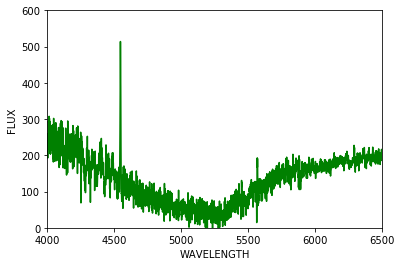

In [42]:
#saving combined 1D & then added overlap graphs for talk
plt.plot(wl_both,rbspec,color='g')
plt.xlabel('WAVELENGTH')
plt.ylabel('FLUX')

#for 1D
#plt.ylim(0,plt.ylim()[-1])
#plt.savefig('complete1D.pdf', format='pdf', dpi=1200)

#for added overlap
plt.ylim(0,600)
plt.xlim(4000,6500)
plt.savefig('added_overlap.pdf', format='pdf', dpi=1200)

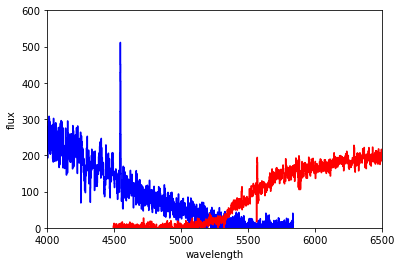

In [43]:
#saving overlap graph for talk 
plt.step(wl_blue15, flux_blue15,'b')
plt.step(wl_red15,flux_red15,'r')
plt.xlim(4000,6500)
plt.ylim(0,600)
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.savefig('overlap.pdf', format='pdf', dpi=1200)

In [ ]:
#saving stuff here incase git fucks me over


#okay trying again with cutting xarray to just around target...but doesnt this defeat the purpose?
#going back to original zero centered y data with x originals aka ytest & xtest
allzero = Table([ytest,xtest],names=('y','x')) #reusing
peak = max(allzero['y'])
peakrow = np.where(allzero['y']==peak)
#allzero[peakrow]
lower = int(peakrow-np.array(10))
upper = int(peakrow+np.array(10))
selectedx = allzero[lower:upper]
#selectedx #table of area around peak
#CAUTION! this will only work if theres only one peak!, wont detect multiple peaks
#------------------------------------------------------------------------------
#trying centroid around with only the subselected area around peak data
subx = selectedx['x']
suby = selectedx['y']
top_arr3 = suby * subx
top3 = sum(top_arr3)
bottom3 = sum(suby)
c = top3/bottom3
print('this is c:',c) #this might have worked!
#-----------------------------------------------------------------------------
plt.plot(xtest,ytest) #zero centered data
plt.plot(c,max(suby),'o',markersize=10) #centroid
plt.plot(x,y,'g') #original original data
plt.title('Centroid worked!!')
#----------------------------------------------------------------------------
#final test want to see if centroid will work w/o zero-centering y data

#nameing things
top_table2 = Table([x,y],names=('x','y')) #reusing this one with some amending
peak2 = max(top_table2['y'])
peakrow2 = np.where(top_table2['y']==peak2)
lower2 = int(peakrow2-np.array(10))
upper2 = int(peakrow2+np.array(10))
selectedx2 = top_table2[lower2:upper2]

#centroid method
subx2 = selectedx2['x']
suby2 = selectedx2['y']
top_arr4 = suby2 * subx2
top4 = sum(top_arr4)
bottom4 = sum(suby2)
c = top4/bottom4
print('this is c:',c) #interesting....this is close but not the same off by ~0.3

